In [15]:
import re
import sys
import os
import yaml
import pandas as pd
import mlflow
import subprocess
from mlflow import MlflowClient

from pathlib import Path
from pydantic import BaseModel
from typing import Optional, List
from collections import namedtuple

from visualize.plots import (
    plot_f1_score,
    plot_f1_score_line_plot,
)

from visualize.mlflow_utils import get_last_n_runs, runs_to_df

from src.util.logging import Pickler
from src.util.constants import Directory

In [16]:
pd.set_option("display.precision", 4)

In [17]:
class Dataset(BaseModel):

    id: str
    name: str
    runs: int
    query: str

In [40]:
def get_data(name: str, query: str, n_runs: int) -> pd.DataFrame:

    result = subprocess.run([f"{sys.executable}", "visualize\mlflow_utils.py", "--filename", name, "--query", query, "--n_runs", str(n_runs)], stderr=subprocess.PIPE, text=True)
    
    # Check the status
    if result.returncode == 0:
        print("Config creation successful.")
    else:
        print(f"Subprocess failed with return code {result.returncode}.")
        print("Error output:")
        print(result.stderr)
        raise ValueError("Subprocess exited unexpectedly")
    
    vis_dir = Directory.ROOT / 'notebooks/visualize'
    datasets_filename = vis_dir / f"{name}.yaml"

    with open(datasets_filename, "r") as file:
        datasets = yaml.safe_load(file)

    # reformatting datasets for easier access
    datasets = [Dataset(name=key, **values) for key, values in datasets.items()]
    
    # result
    result = []

    for dataset in datasets:

        runs = get_last_n_runs(
            experiment_id=dataset.id, n=dataset.runs, query=dataset.query
        )

        if len(runs) == 0:
            raise ValueError("No runs found")
        
        data = runs_to_df(runs)
        
        result.append(data)
        
    return pd.concat(result)

def get_artifact_paths(directory: str):
    
    artifacts = list(Path(directory[6:]).glob('*'))
    
    return artifacts

def get_artifact_by_name(name: str, artifacts: List):
    
    result = [el for el in artifacts if name in str(el)]
    
    assert len(result) == 1
    
    return result[0]

## Feature Selection Analysis

In [50]:
data = get_data(name='xgb', n_runs=1, query="%synthetic__feat%")
directory = data["artifact_uri"].head(1).values[0]
artifacts = get_artifact_paths(directory=directory)
path_to_artifact = get_artifact_by_name(name='conf_target', artifacts=artifacts)

Config creation successful.


(10, 25)
                 avg_target  mean_confidence
avg_target           1.0000           0.8414
mean_confidence      0.8414           1.0000
PearsonRResult(statistic=0.8413956304311703, pvalue=0.0011377930384262784)


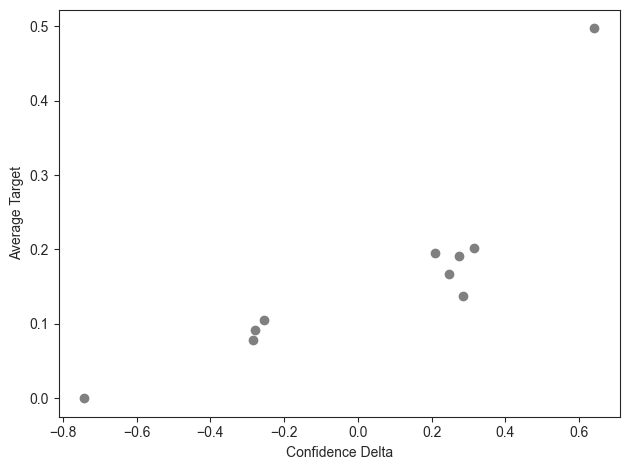

<Figure size 640x480 with 0 Axes>

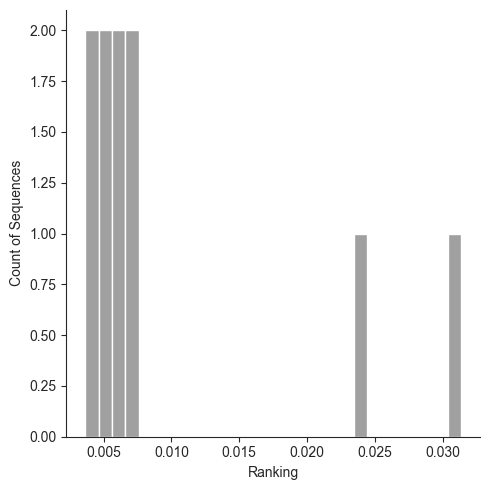

In [51]:
def rule_conf_analysis(path_to_artifact):
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    from scipy.stats import pearsonr
    
    sns.set_style('white')
        
    data = Pickler.load(path_to_artifact)
                        
    data['avg_target'] /= 1
    mask = data['mean_ranking'] > 0.001 # 0.001
    mask = data['mean_support'] > 0.01
    
    print(data[mask].shape)
    
    print(data[['avg_target', 'mean_confidence']][mask].corr())
    print(pearsonr(data['avg_target'][mask], data['mean_confidence'][mask], alternative='greater'))
    
    #print(data[mask][['index', 'avg_target', 'mean_confidence', 'mean_support', 'mean_ranking']].sort_values(by='avg_target'))
    #data[mask].plot(kind='scatter', x='mean_confidence', y='avg_target')
    
    data.rename({'avg_target': 'Average Target', 'mean_confidence': 'Confidence Delta', 'mean_ranking': 'Ranking'}, axis=1, inplace=True)
    sns.scatterplot(data=data[mask], x='Confidence Delta', y='Average Target', color='grey', linewidth=1, edgecolor='grey', markers='x')
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    plt.tight_layout()
    plt.savefig('scatter_feat_selection.pdf', dpi=300)
    plt.show()
    
    plt.figure()
    sns.displot(data=data[mask], x='Ranking', binwidth=0.001, color='grey')
    plt.ylabel('Count of Sequences')
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    plt.tight_layout()
    plt.savefig('hist_ranking_feat_selection.pdf', dpi=300)
    plt.show()
     
rule_conf_analysis(path_to_artifact=path_to_artifact)

In [52]:
path_to_artifact = get_artifact_by_name(name='logging', artifacts=artifacts)

In [55]:
def rule_log_analysis(path_to_artifact=path_to_artifact):
    
    data = Pickler.load(path_to_artifact)
    
    keys = data.keys()
    
    for key in keys:
        
        df = data[key]
        
        rules = df['index']
        print(key, len(df))
        print(rules.apply(lambda x: len(list(filter(None, x.split(' --> '))))).mean())
        
    
rule_log_analysis()

0_bootstrapped 3259
3.545872967167843
1_significant_greater 247
4.040485829959514
2_select_shorter_start_end 94
3.4148936170212765
3_select_shorter_subsequence 58
3.3448275862068964


## Classification Analysis

In [5]:
data = get_data(name='sim', query='clf_sim_*', n_runs=99)
data

,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,check_execution,evaluation.class_name,evaluation.params.metrics,evaluation.params.metrics_proba,export.class_name,...,preprocess.params.steps.3.params.split_col,preprocess.params.steps.3.params.split_type,preprocess.params.steps.3.params.target_name,preprocess.params.steps.3.params.test_size,preprocess.params.steps.4.class_name,preprocess.params.steps.4.params.columns,sparsity,end_time,run_id,artifact_uri
0,1.0000,1.0000,1.000,1.0000,1.0000,False,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,...,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",0.5,1699653738519,5095f878745340daa9c26d60f2320ff8,file:\c:\users\algrote\desktop\process_analyse...
1,1.0000,1.0000,1.000,1.0000,1.0000,False,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,...,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",0.5,1699653511041,a51899a2156a4bf7b1338adbbebf44ed,file:\c:\users\algrote\desktop\process_analyse...
2,1.0000,1.0000,1.000,1.0000,1.0000,False,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,...,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",0.5,1699653290968,8fda96208eaa4f4788255162ce1e79ec,file:\c:\users\algrote\desktop\process_analyse...
3,1.0000,1.0000,1.000,1.0000,1.0000,False,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,...,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",0.5,1699653070085,1f8d4936d62d4881b1abf203221ca6fd,file:\c:\users\algrote\desktop\process_analyse...
4,1.0000,1.0000,1.000,1.0000,1.0000,False,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,...,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",0.5,1699652848675,955bea96682d4c898c79b3c0ad9c5ebf,file:\c:\users\algrote\desktop\process_analyse...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.8380,0.8332,0.852,0.8151,0.8815,False,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,...,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1,1699658763534,9a55df19129446fbbe62653e15fd00f2,file:\c:\users\algrote\desktop\process_analyse...
1,0.8380,0.8332,0.852,0.8151,0.8815,False,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,...,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1,1699658645106,c5187acbf5a84e36a3bc2355c63094cd,file:\c:\users\algrote\desktop\process_analyse...
2,0.8380,0.8332,0.852,0.8151,0.8815,False,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,...,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1,1699658522749,805dc77dda4e47c3be2ef39a291604e3,file:\c:\users\algrote\desktop\process_analyse...
3,0.8380,0.8332,0.852,0.8151,0.8815,False,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,...,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1,1699658406301,ba667b7e21a643d9b5b173e03488751d,f

In [6]:
def analysis_clf(df: pd.DataFrame):
    
    dfc = df.copy(deep=True)
    
    
    
    sparsity_column = 'sparsity'
    dfc.rename({'fetch_data.params.time_series_positive.params.sequence_generator.params.sequence_weights.a_c': 'sparsity'}, inplace=True, axis=1)
    metric_columns = ['accuracy_score', 'f1_score']
    
    
    print(dfc.groupby(sparsity_column)[metric_columns].agg(['mean', 'std']))

analysis_clf(df=data)

         accuracy_score           f1_score          
                   mean       std     mean       std
sparsity                                            
0.1                0.83  9.64e-03     0.83  1.13e-02
0.2                0.84  7.91e-05     0.84  8.03e-04
0.3                0.84  1.90e-03     0.85  4.58e-04
0.4                0.86  2.06e-03     0.85  4.40e-03
0.5                0.85  2.34e-02     0.85  2.30e-02
0.6                0.85  2.71e-02     0.85  2.71e-02
0.7                0.86  2.90e-02     0.86  2.88e-02
0.8                0.88  3.23e-02     0.88  3.20e-02
0.9                0.89  3.98e-02     0.89  3.70e-02
1                  0.93  4.80e-02     0.94  4.72e-02


In [7]:
pos_col = 'fetch_data.params.time_series_positive.params.sequence_generator.params.sequence_weights.a_c'
neg_col = 'fetch_data.params.time_series_negative.params.sequence_generator.params.sequence_weights.a_c'

noise = 'noise'
sparsity = 'sparsity'
random_seed = 'fetch_data.params.static_dataset.params.random_seed'

metric = 'f1_score'

In [34]:
data[pos_col].max()

'1.0'

In [44]:
data.filter(like='random')

,fetch_data.params.static_dataset.params.random_seed,preprocess.params.steps.3.params.random_state
0,4,42
1,3,42
2,2,42
3,1,42
4,0,42
...,...,...
0,4,42
1,3,42
2,2,42
3,1,42


In [8]:
for col in [noise, sparsity]:
    data[col] = data[col].astype(float)

In [39]:
df = data[[noise, sparsity, metric]]
df.groupby([noise, sparsity]).size()[df.groupby([noise, sparsity]).size() != 5]

noise  sparsity
0.0    0.9         3
0.1    1.0         4
0.4    1.0         4
dtype: int64

In [10]:
from scipy.stats import ttest_1samp

for noise_score in data[noise].unique():
    for sparsity_score in data[sparsity].unique():
        
        mask = (data[noise] == noise_score) * (data[sparsity] == sparsity_score)
        df_sub = data[mask]
        
        test_result = ttest_1samp(a=df_sub[metric], popmean=0.8377, alternative='greater')
        
        p_val = test_result.pvalue
        
        if test_result.pvalue <= 0.1:
            star = "+"
            
            if p_val < 0.05:
                star = "*"
                
            if p_val < 0.01:
                star = "**"
                
            if p_val < 0.001:
                star = "***"
                
            print(noise_score, sparsity_score, star, df_sub[metric].mean())

0.0 0.5 *** 1.0
0.0 0.6 *** 0.9190480876651869
0.0 0.7 *** 0.8839339655667974
0.1 0.5 *** 0.902465317169999
0.1 0.6 *** 0.8761632542783904
0.1 0.7 * 0.8512999246204128
0.2 0.5 *** 0.8648588611705748
0.2 0.6 + 0.8513590490668017
0.3 0.5 ** 0.8565887445887446


In [50]:
class Outlier(BaseModel):
    
    noise: float
    sparsity: float
    random_seed: int

In [91]:
def round_numbers_to_2_decimals(input_string):
    def round_match(match):
        return '{:.2f}'.format(float(match.group(0)))

    pattern = r'\d+\.\d+'
    result = re.sub(pattern, round_match, input_string)

    return result

def combine_strings(str1, str2):
    words1 = str1.split()
    words2 = str2.split()
    
    combined = f"{round(float(words1[0]), 1)} " + ' '.join(f'{w1}±{w2}' for w1, w2 in zip(words1[1:-1], words2[1:-1])) + f" {words1[-1]}"
    combined = combined.replace('&±&', '&')

    return combined

In [95]:
pd.pivot_table(data=df, index=[noise], columns=[sparsity], values=[metric], aggfunc={metric: ['mean', 'std']})

f1_score                                                          \
             mean                                             std           
sparsity      0.5     0.6     0.7     0.8     0.9     1.0     0.5     0.6   
noise                                                                       
0.0        1.0000  0.9190  0.8839  0.8417  0.8307  0.8377  0.0000  0.0018   
0.1        0.9025  0.8762  0.8513  0.8384  0.8325  0.8366  0.0031  0.0060   
0.2        0.8649  0.8514  0.8345  0.8291  0.8424  0.8350  0.0047  0.0147   
0.3        0.8566  0.8333  0.8127  0.8442  0.8375  0.8326  0.0090  0.0080   
0.4        0.8352  0.8263  0.8370  0.8264  0.8351  0.8381  0.0032  0.0103   
0.5        0.8341  0.8260  0.8355  0.8370  0.8342  0.8305  0.0118  0.0143   
0.6        0.8400  0.8204  0.8336  0.8342  0.8362  0.8382  0.0179  0.0296   
0.7        0.8369  0.8277  0.8407  0.8338  0.8402  0.8287  0.0083  0.0123   
0.8        0.8382  0.8362  0.8453  0.8333  0.8315  0.8341  0.0113  0.0187   
0.9        0.8370  0.8427  0.8321  0.8360  0.8278  0.8306  0.0085  0.0213   
1.0        0.8393  0.8333  0.8336  0.8374  0.8329  0.8384  0.0137  0.0003   

                                          
                                          
sparsity     0.7     0.8     0.9     1.0  
noise                                     
0.0       0.0003  0.0122  0.0003  0.0101  
0.1       0.0099  0.0129  0.0229  0.0069  
0.2       0.0069  0.0025  0.0296  0.0040  
0.3       0.0046  0.0256  0.0183  0.0013  
0.4       0.0003  0.0058  0.0079  0.0099  
0.5       0.0095  0.0085  0.0023  0.0059  
0.6       0.0075  0.0024  0.0182  0.0112  
0.7       0.0169  0.0014  0.0158  0.0100  
0.8       0.0272  0.0002  0.0038  0.0021  
0.9       0.0024  0.0063  0.0119  0.0056  
1.0       0.0009  0.0096  0.0005  0.0117

In [92]:
latex_str_mean = pd.pivot_table(data=df, index=[noise], columns=[sparsity], values=[metric], aggfunc={metric: ["mean"]}).to_latex()
latex_str_std = pd.pivot_table(data=df, index=[noise], columns=[sparsity], values=[metric], aggfunc={metric: ['std']}).to_latex()

latex_str_mean = round_numbers_to_2_decimals(latex_str_mean)
latex_str_std = round_numbers_to_2_decimals(latex_str_std)

print(latex_str_mean)

latex_str_mean_rows = latex_str_mean.split('\n')
latex_str_std_rows = latex_str_std.split('\n')

result = []

for latex_str_mean_row, latex_str_std_row in zip(latex_str_mean_rows, latex_str_std_rows):
    
    if len(latex_str_mean_row) == 0:
        continue
    
    if latex_str_mean_row[0].isdigit():
        
        new_row = combine_strings(latex_str_mean_row, latex_str_std_row)
        result.append(new_row)
        continue
        
    result.append(latex_str_mean_row)
    
print('\n'.join(result))

\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{6}{r}{f1_score} \\
 & \multicolumn{6}{r}{mean} \\
sparsity & 0.50 & 0.60 & 0.70 & 0.80 & 0.90 & 1.00 \\
noise &  &  &  &  &  &  \\
\midrule
0.00 & 1.00 & 0.92 & 0.88 & 0.84 & 0.83 & 0.84 \\
0.10 & 0.90 & 0.88 & 0.85 & 0.84 & 0.83 & 0.84 \\
0.20 & 0.86 & 0.85 & 0.83 & 0.83 & 0.84 & 0.83 \\
0.30 & 0.86 & 0.83 & 0.81 & 0.84 & 0.84 & 0.83 \\
0.40 & 0.84 & 0.83 & 0.84 & 0.83 & 0.84 & 0.84 \\
0.50 & 0.83 & 0.83 & 0.84 & 0.84 & 0.83 & 0.83 \\
0.60 & 0.84 & 0.82 & 0.83 & 0.83 & 0.84 & 0.84 \\
0.70 & 0.84 & 0.83 & 0.84 & 0.83 & 0.84 & 0.83 \\
0.80 & 0.84 & 0.84 & 0.85 & 0.83 & 0.83 & 0.83 \\
0.90 & 0.84 & 0.84 & 0.83 & 0.84 & 0.83 & 0.83 \\
1.00 & 0.84 & 0.83 & 0.83 & 0.84 & 0.83 & 0.84 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{6}{r}{f1_score} \\
 & \multicolumn{6}{r}{mean} \\
sparsity & 0.50 & 0.60 & 0.70 & 0.80 & 0.90 & 1.00 \\
noise &  &  &  &  &  &  \\
\midrule
0.0 & 1.00±0.00 & 0.92±0.00 & 0.88±0.00 & 0

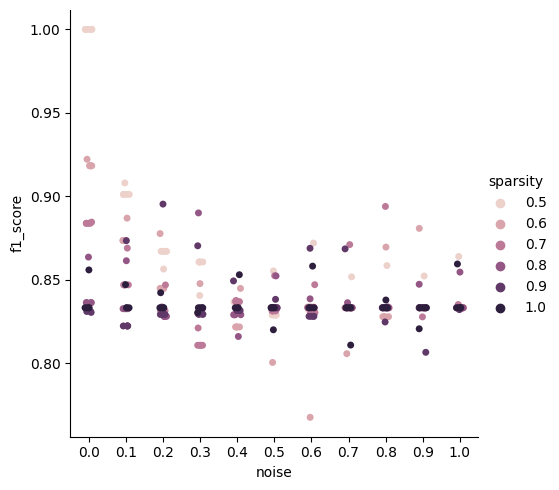

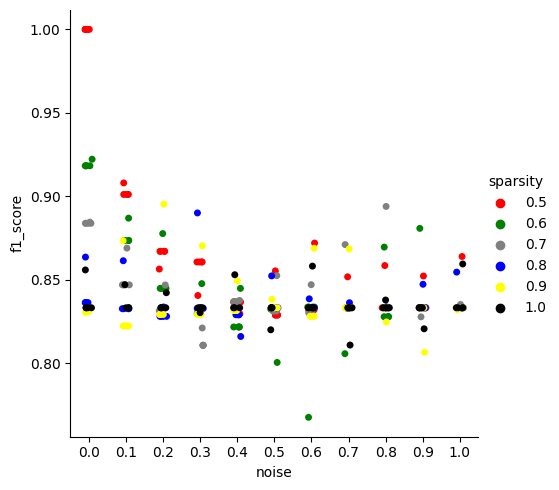

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data=df, x=noise, y=metric, hue=sparsity)
plt.show()

sns.catplot(data=df, x=noise, y=metric, hue=sparsity, palette=sns.color_palette(['red', 'green', 'grey', 'blue', 'yellow', 'black']))
plt.show()

In [ ]:
outliers = [
    Outlier()
]

## Runtime Analysis

In [97]:
data = get_data(name='runtime', query='runtime', n_runs=99)
data

,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,evaluation.class_name,evaluation.params.metrics,evaluation.params.metrics_proba,export.class_name,export.params.experiment_name,...,preprocess.params.steps.3.params.random_state,preprocess.params.steps.3.params.split_col,preprocess.params.steps.3.params.split_type,preprocess.params.steps.3.params.target_name,preprocess.params.steps.3.params.test_size,preprocess.params.steps.4.class_name,preprocess.params.steps.4.params.columns,end_time,run_id,artifact_uri
0,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699115825573,c0bb3673e44c4a79a23cf336bb3be283,file:\c:\users\algrote\desktop\process_analyse...
1,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699115306972,ee4c6a081a80412ab84d4eca0e3000bb,file:\c:\users\algrote\desktop\process_analyse...
2,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699114853481,3310042fa92744f19bd3d9e770a256e0,file:\c:\users\algrote\desktop\process_analyse...
3,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699114495898,fbd8b7806c1c4f768ae46548c74ec9d2,file:\c:\users\algrote\desktop\process_analyse...
4,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699114255039,4e38fb3294754ddf853ffb4cdbd61e90,file:\c:\users\algrote\desktop\process_analyse...
5,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699114092433,ff2b14af8c0743339783a5cd42b006de,file:\c:\users\algrote\desktop\process_analyse...
6,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699114008999,a9475dc4ce154dc394e9352ce521d8b1,file:\c:\users\algrote\desktop\process_analyse...
7,0.9067,0.9070,0.8978,0.9164,0.9626,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699113950808,7c017354d52d4128a01b4e6794b8c197,file:\c:\users\algrote\desktop\process_analyse...
8,0.9075,0.9121,0.8864,0.9393,0.9588,src.evaluation.sklearn_metrics.Evaluator,"sklearn.metrics.accuracy_score,sklearn.metrics...",sklearn.metrics.roc_auc_score,src.export.mlflow.Exporter,runtime,...,42,id_column,column_based,target,0.2,src.preprocess.excluder.ColumnExcluder,"index,id_column",1699113908820,cef3fad7ccc9492eba0b9af913fac6e8,file:\c:\use

<Figure size 640x480 with 0 Axes>

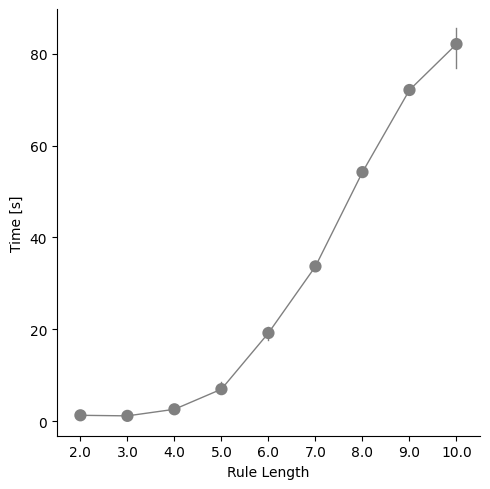

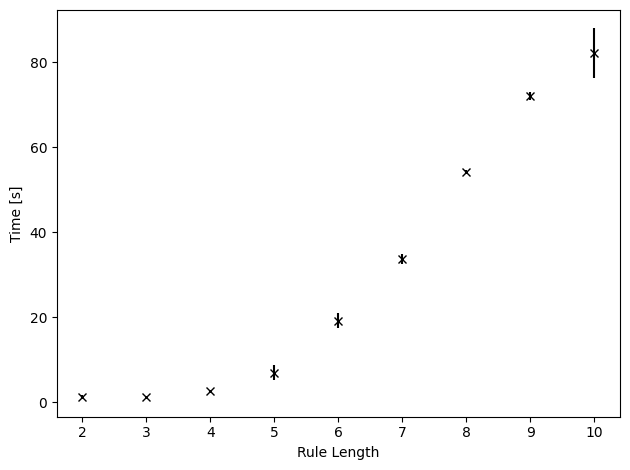

In [145]:
def analyse_mining_time(df: pd.DataFrame):
    
    import yaml
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    
    col_rule = 'rule_length'
    col_time = 'time'
    
    result = pd.DataFrame(columns=[col_rule, col_time])
    
    for idx, row in df.iterrows():
        
        uri = row['artifact_uri'][6:]
        rule_length = row['preprocess.params.steps.1.params.prefixspan_config.params.itertool_threshold']
        
        with open(Path(uri) / 'time.yaml') as file:
            times = yaml.safe_load(file)['rule_mining']
            
            # outlier
            if rule_length == '2':
                times.pop(0)
            tmp = pd.DataFrame({col_time: times, col_rule: rule_length})
            result = pd.concat([result, tmp])
    
    result[col_rule] = result[col_rule].astype(float)
            
    df_agg = result.groupby(col_rule).agg(['mean', 'std']).reset_index()
    df_agg.columns = [col_rule, 'mean', 'std']
    
    plt.figure()
    
    g = sns.catplot(data=result, x=col_rule, y=col_time, kind='point', color='grey')
    
    ax = g.facet_axis(0, 0)
    
    for line in ax.lines:
        line.set_linewidth(1)
        
    # Create a scatter plot to control edge color
    #scatter = ax.scatter(df_agg[col_rule], df_agg['mean'], marker='o', edgecolors='red', facecolors='none', s=100)

    
    plt.xlabel('Rule Length')
    plt.ylabel('Time [s]')
    plt.tight_layout()
    plt.savefig('runtime_catplot.pdf', dpi=300)
    plt.show()
    
    plt.figure()
    plt.errorbar(
        df_agg[col_rule].values, 
        df_agg['mean'].values, 
        df_agg['std'].values, 
        linestyle='None', 
        marker='x',
        color='black',
        ecolor='black'
    )
    plt.xlabel('Rule Length')
    plt.ylabel('Time [s]')
    plt.tight_layout()
    plt.savefig('runtime.pdf', dpi=300)
    plt.show()
    
analyse_mining_time(df=data)

## Other Debugging

In [ ]:
from src.preprocess.ts_feature_selection import RuleClassifier

clf = RuleClassifier(rule=['a', 'c'])

sequences=[
    ['a', 'b', 'c'],
    ['a', 'c'],
    ['a', 'a', 'c'],
    ['a', 'b', 'b', 'c'],
    ['b', 'a', 'd', 'c']
]

for seq in sequences:
    print(clf.apply_rule(seq), '\t', seq)